## CHEST RAY CLASSIFICATION USING CNN


In [3]:
import os  # for file/directory operations
import cv2  # computer vision library for image processing
import numpy as np  # array operations and math functions
import random  # for shuffling and sampling
from tqdm import tqdm  # to visualize long-running operations
from collections import Counter  # for counting frequency of elements
import matplotlib.pyplot as plt  # for creating graphs and charts
import seaborn as sns  # enhanced plotting with better aesthetics
from sklearn.model_selection import train_test_split  # for splitting data into train/test sets

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from PIL import Image

In [4]:
data_dir = "chest_xray/train"

### Step 2: EDA (Exploratory Data Analysis)

#### Goals:

Inspect image dimensions.

Check class distribution.

Visualize some samples.

NORMAL: 1341 images
PNEUMONIA: 3875 images


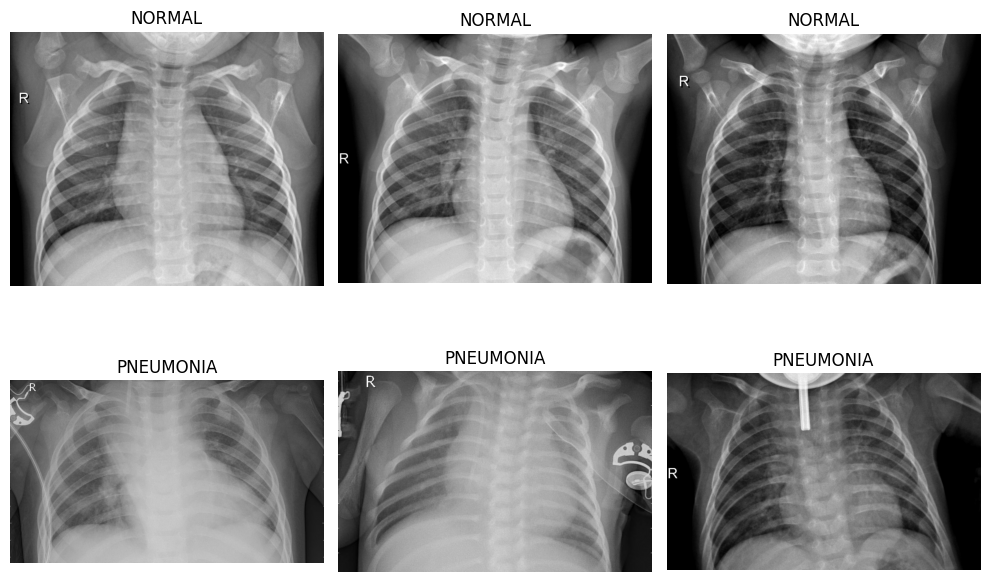

In [8]:
# Count images per class
for category in ["NORMAL", "PNEUMONIA"]:
    folder = os.path.join(data_dir, category)
    print(f"{category}: {len(os.listdir(folder))} images")

# Display random samples
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
for i, category in enumerate(["NORMAL", "PNEUMONIA"]):
    for j in range(3):
        img_path = random.choice(os.listdir(os.path.join(data_dir, category)))
        img = Image.open(os.path.join(data_dir, category, img_path))
        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].set_title(category)
        ax[i, j].axis('off')
plt.tight_layout()
plt.show()

### Step 3: Data Preprocessing

Use ImageDataGenerator to:

Normalize pixel values.

Augment training data.

In [9]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    'chest_xray/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_gen = val_test_datagen.flow_from_directory(
    'chest_xray/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_gen = val_test_datagen.flow_from_directory(
    'chest_xray/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Step 4: Model Building

We’ll use a CNN with transfer learning (VGG16) for better accuracy.

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False  # freeze feature extractor

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,521 (60.13 MB)

 Trainable params: 1,048,833 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Step 5: Training the Model

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_pneumonia_model.h5', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)


c:\Users\isaia\Documents\Zindua\ADVML\ML-2-Capstone\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8411 - loss: 0.3533

163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 645ms/step - accuracy: 0.8930 - loss: 0.2543 - val_accuracy: 0.8750 - val_loss: 0.3129
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 717ms/step - accuracy: 0.9293 - loss: 0.1745 - val_accuracy: 0.8125 - val_loss: 0.3446
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 763ms/step - accuracy: 0.9377 - loss: 0.1536 - val_accuracy: 0.7500 - val_loss: 0.5022
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.9466 - loss: 0.1443

163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 749ms/step - accuracy: 0.9463 - loss: 0.1407 - val_accuracy: 0.8750 - val_loss: 0.3042
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.9418 - loss: 0.1509

163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 756ms/step - accuracy: 0.9469 - loss: 0.1385 - val_accuracy: 0.8125 - val_loss: 0.2575
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 751ms/step - accuracy: 0.9521 - loss: 0.1278 - val_accuracy: 0.7500 - val_loss: 0.5759
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 764ms/step - accuracy: 0.9528 - loss: 0.1242 - val_accuracy: 0.8750 - val_loss: 0.2783
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 762ms/step - accuracy: 0.9519 - loss: 0.1258 - val_accuracy: 0.7500 - val_loss: 0.5952
Epoch 9/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 930ms/step - accuracy: 0.9622 - loss: 0.1081 - val_accuracy: 0.8750 - val_loss: 0.2971
Epoch 10/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9593 - loss: 0.1112

163/163 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.9595 - loss: 0.1132 - val_accuracy: 0.8125 - val_loss: 0.1976
Epoch 11/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 784ms/step - accuracy: 0.9590 - loss: 0.1137 - val_accuracy: 0.8750 - val_loss: 0.2833
Epoch 12/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 813ms/step - accuracy: 0.9592 - loss: 0.1058 - val_accuracy: 0.8750 - val_loss: 0.2323
Epoch 13/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9593 - loss: 0.1123

163/163 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.9567 - loss: 0.1132 - val_accuracy: 0.8750 - val_loss: 0.1818
Epoch 14/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.9620 - loss: 0.1038 - val_accuracy: 0.8750 - val_loss: 0.2443
Epoch 15/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 776ms/step - accuracy: 0.9597 - loss: 0.1012 - val_accuracy: 0.8750 - val_loss: 0.2627


### Step 6: Evaluation

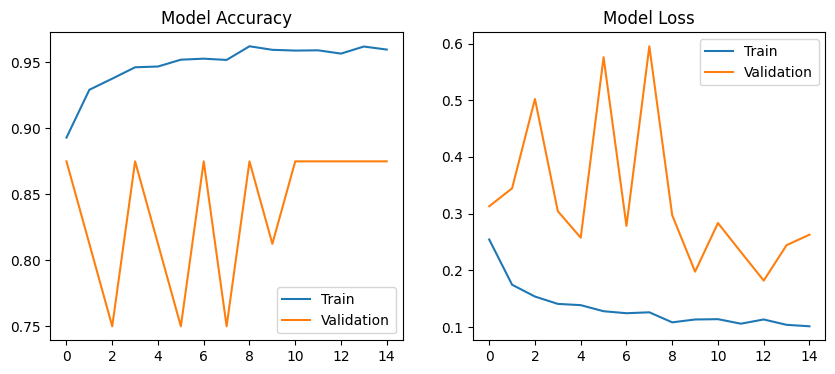

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 654ms/step - accuracy: 0.9167 - loss: 0.2186
Test Accuracy: 91.67%
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 686ms/step
              precision    recall  f1-score   support

      Normal       0.92      0.85      0.88       234
   Pneumonia       0.91      0.96      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Plot accuracy & loss curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Confusion matrix
preds = model.predict(test_gen)
y_pred = (preds > 0.5).astype(int)
print(classification_report(test_gen.classes, y_pred, target_names=['Normal','Pneumonia']))


### Step 7: Model Explainability (Grad-CAM)

This step is critical in medicine to understand why your model made a decision.

In [14]:
import os

# Check where your pneumonia test images actually are
base_dir = "chest_xray/test/PNEUMONIA"
print(os.listdir(base_dir)[:10])  # Show first 10 files in the folder


['person100_bacteria_475.jpeg', 'person100_bacteria_477.jpeg', 'person100_bacteria_478.jpeg', 'person100_bacteria_479.jpeg', 'person100_bacteria_480.jpeg', 'person100_bacteria_481.jpeg', 'person100_bacteria_482.jpeg', 'person101_bacteria_483.jpeg', 'person101_bacteria_484.jpeg', 'person101_bacteria_485.jpeg']


Testing image: chest_xray/test/PNEUMONIA\person126_bacteria_599.jpeg


c:\Users\isaia\Documents\Zindua\ADVML\ML-2-Capstone\env\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


AttributeError: AxesImage.set() got an unexpected keyword argument '__annotations__'

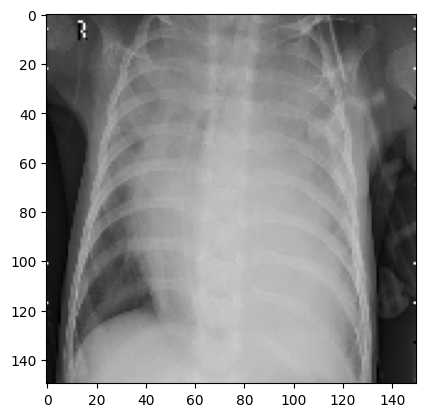

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def get_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Example usage
pneumonia_dir = 'chest_xray/test/PNEUMONIA'
random_img = random.choice(os.listdir(pneumonia_dir))
img_path = os.path.join(pneumonia_dir, random_img)

print("Testing image:", img_path)

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150,150))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)/255.0

last_conv_layer_name = "block5_conv3"
heatmap = get_gradcam_heatmap(img_array, base_model, last_conv_layer_name)

plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5, __annotations__=True)
plt.axis('off')
plt.show()


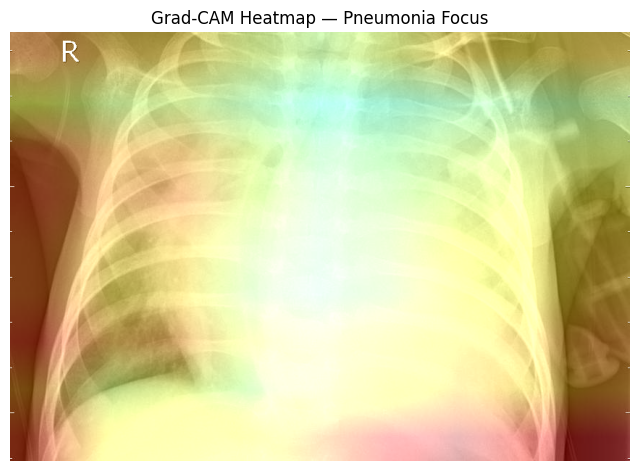

In [29]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Generate Grad-CAM heatmap
heatmap = get_gradcam_heatmap(img_array, base_model, "block5_conv3")

# Load original image
img = tf.keras.preprocessing.image.load_img(img_path)
img = tf.keras.preprocessing.image.img_to_array(img)

# Rescale heatmap to 0–255
heatmap = np.uint8(255 * heatmap)

# Use the updated colormap syntax
jet = plt.colormaps.get_cmap("jet")

# Apply the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Resize and overlay
jet_heatmap = tf.image.resize(tf.convert_to_tensor(jet_heatmap), (img.shape[0], img.shape[1]))
superimposed_img = np.clip(jet_heatmap * 0.4 + img/255.0, 0, 1)

# Display result
plt.figure(figsize=(8,8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.title("Grad-CAM Heatmap — Pneumonia Focus")
plt.show()


### Step 8: Deployment (Streamlit App)

Create a file app.py:

In [ ]:
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np

st.title("🩺 Pneumonia Detection from Chest X-Ray")
st.write("Upload a chest X-ray image to classify as Normal or Pneumonia")

model = tf.keras.models.load_model('best_pneumonia_model.h5')

uploaded_file = st.file_uploader("Choose an X-ray image", type=['jpg', 'jpeg', 'png'])

if uploaded_file:
    img = Image.open(uploaded_file).convert('RGB')
    st.image(img, caption='Uploaded X-ray', use_column_width=True)
    img = img.resize((150, 150))
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)
    
    prediction = model.predict(img_array)
    result = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
    
    st.markdown(f"### 🧾 Prediction: **{result}**")
